## Homework: Evaluation and Monitoring

In this homework, we'll evaluate the quality of our RAG system.

> It's possible that your answers won't match exactly. If it's the case, select the closest one.

Solution:

* Video: TBA
* Notebook: TBA

## Getting the data

Let's start by getting the dataset. We will use the data we generated in the module.

In particular, we'll evaluate the quality of our RAG system
with [gpt-4o-mini](https://github.com/DataTalksClub/llm-zoomcamp/blob/main/04-monitoring/data/results-gpt4o-mini.csv)


Read it:

```python
url = f'{github_url}?raw=1'
df = pd.read_csv(url)
```

We will use only the first 300 documents:


```python
df = df.iloc[:300]
```

## Q1. Getting the embeddings model

Now, get the embeddings model `multi-qa-mpnet-base-dot-v1` from
[the Sentence Transformer library](https://www.sbert.net/docs/sentence_transformer/pretrained_models.html#model-overview)

> Note: this is not the same model as in HW3

```bash
from sentence_transformers import SentenceTransformer
embedding_model = SentenceTransformer(model_name)
```

Create the embeddings for the first LLM answer:

```python
answer_llm = df.iloc[0].answer_llm
```

What's the first value of the resulting vector?

* -0.42
* -0.22
* -0.02
* 0.21


## Q2. Computing the dot product


Now for each answer pair, let's create embeddings and compute dot product between them

We will put the results (scores) into the `evaluations` list

What's the 75% percentile of the score?

* 21.67
* 31.67
* 41.67
* 51.67

## Q3. Computing the cosine

From Q2, we can see that the results are not within the [0, 1] range. It's because the vectors coming from this model are not normalized.

So we need to normalize them.

To do it, we 

* Compute the norm of a vector
* Divide each element by this norm

So, for vector `v`, it'll be `v / ||v||`

In numpy, this is how you do it:

```python
norm = np.sqrt((v * v).sum())
v_norm = v / norm
```

Let's put it into a function and then compute dot product 
between normalized vectors. This will give us cosine similarity

What's the 75% cosine in the scores?

* 0.63
* 0.73
* 0.83
* 0.93

## Q4. Rouge

Now we will explore an alternative metric - the ROUGE score.  

This is a set of metrics that compares two answers based on the overlap of n-grams, word sequences, and word pairs.

It can give a more nuanced view of text similarity than just cosine similarity alone.

We don't need to implement it ourselves, there's a python package for it:

```bash
pip install rouge
```

(The latest version at the moment of writing is `1.0.1`)

Let's compute the ROUGE score between the answers at the index 10 of our dataframe (`doc_id=5170565b`)

```
from rouge import Rouge
rouge_scorer = Rouge()

scores = rouge_scorer.get_scores(r['answer_llm'], r['answer_orig'])[0]
```

There are three scores: `rouge-1`, `rouge-2` and `rouge-l`, and precision, recall and F1 score for each.

* `rouge-1` - the overlap of unigrams,
* `rouge-2` - bigrams,
* `rouge-l` - the longest common subsequence

What's the F score for `rouge-1`?

- 0.35
- 0.45
- 0.55
- 0.65

## Q5. Average rouge score

Let's compute the average F-score between `rouge-1`, `rouge-2` and `rouge-l` for the same record from Q4

- 0.35
- 0.45
- 0.55
- 0.65

## Q6. Average rouge score for all the data points

Now let's compute the score for all the records and create a dataframe from them.

What's the average `rouge_2` across all the records?

- 0.10
- 0.20
- 0.30
- 0.40



## Submit the results

* Submit your results here: https://courses.datatalks.club/llm-zoomcamp-2024/homework/hw4
* It's possible that your answers won't match exactly. If it's the case, select the closest one.

In [1]:
import pandas as pd
import numpy as np
from sentence_transformers import SentenceTransformer
from tqdm.auto import tqdm
import seaborn as sns
import matplotlib.pyplot as plt
from rouge import Rouge

/home/vesna/.pyenv/versions/3.12.1/lib/python3.12/site-packages/sentence_transformers/cross_encoder/CrossEncoder.py:11: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm, trange


In [2]:
url = 'https://github.com/DataTalksClub/llm-zoomcamp/blob/main/04-monitoring/data/results-gpt4o-mini.csv?raw=1'
df = pd.read_csv(url)

In [3]:
df = df.iloc[:300]
df

,answer_llm,answer_orig,document,question,course
0,You can sign up for the course by visiting the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Where can I sign up for the course?,machine-learning-zoomcamp
1,You can sign up using the link provided in the...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Can you provide a link to sign up?,machine-learning-zoomcamp
2,"Yes, there is an FAQ for the Machine Learning ...",Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Is there an FAQ for this Machine Learning course?,machine-learning-zoomcamp
3,The context does not provide any specific info...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,Does this course have a GitHub repository for ...,machine-learning-zoomcamp
4,To structure your questions and answers for th...,Machine Learning Zoomcamp FAQ\nThe purpose of ...,0227b872,How can I structure my questions and answers f...,machine-learning-zoomcamp
...,...,...,...,...,...
295,An alternative way to load the data using the ...,Above users showed how to load the dataset dir...,8d209d6d,What is an alternative way to load the data us...,machine-learning-zoomcamp
296,You can directly download the dataset from Git...,Above users showed how to load the dataset dir...,8d209d6d,How can I directly download the dataset from G...,machine-learning-zoomcamp
297,You can fetch data for homework using the `req...,Above users showed how to load the dataset dir...,8d209d6d,Could you share a method to fetch data for hom...,machine-learning-zoomcamp
298,If the status code is 200 when downloading dat...,Above users showed how to load the dataset dir...,8d209d6d,What should I do if the status code is 200 whe...,machine-learning-zoomcamp


## Q1. Getting the embeddings model

In [4]:
embedding_model = SentenceTransformer('multi-qa-mpnet-base-dot-v1')

In [5]:
answer_llm = df.iloc[0].answer_llm
answer_llm

'You can sign up for the course by visiting the course page at [http://mlzoomcamp.com/](http://mlzoomcamp.com/).'

In [6]:
v_answer_llm = embedding_model.encode(answer_llm)
v_answer_llm

array([-4.22446579e-01, -2.24856094e-01, -3.24058473e-01, -2.84758508e-01,
        7.25637982e-03,  1.01186477e-01,  1.03716679e-01, -1.89983442e-01,
       -2.80597862e-02,  2.71588922e-01, -1.15337484e-01,  1.14666171e-01,
       -8.49585980e-02,  3.32365513e-01,  5.52722663e-02, -2.22195774e-01,
       -1.42540708e-01,  1.02519087e-01, -1.52333796e-01, -2.02912658e-01,
        1.98424123e-02,  8.38147700e-02, -5.68632305e-01,  2.32842825e-02,
       -1.67292669e-01, -2.39256859e-01, -8.05463567e-02,  2.57082582e-02,
       -8.15465227e-02, -7.39290714e-02, -2.61549950e-01,  1.92575473e-02,
        3.22909385e-01,  1.90357044e-01, -9.34726413e-05, -2.13165492e-01,
        2.88941171e-02, -1.79531835e-02, -5.92757724e-02,  1.99918330e-01,
       -4.75172400e-02,  1.71634063e-01, -2.45916881e-02, -9.38061625e-02,
       -3.57002705e-01,  1.33263960e-01,  1.94045797e-01, -1.18530668e-01,
        4.56915230e-01,  1.47728100e-01,  3.35945100e-01, -1.86959475e-01,
        2.45955020e-01, -

In [7]:
print('Q1 =', v_answer_llm[0])

Q1 = -0.42244658


## Q2. Computing the dot product

In [8]:
def compute_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = embedding_model.encode(answer_llm)
    v_orig = embedding_model.encode(answer_orig)
    
    return v_llm.dot(v_orig)

In [9]:
similarity = []

for i, record in tqdm(df.iterrows(), total=df.shape[0]):
    sim = compute_similarity(record)
    similarity.append(sim)

  0%|          | 0/300 [00:00<?, ?it/s]

In [10]:
df['cosine'] = similarity
df['cosine'].describe()

count    300.000000
mean      27.495996
std        6.384742
min        4.547924
25%       24.307847
50%       28.336872
75%       31.674312
max       39.476013
Name: cosine, dtype: float64

In [11]:
percentile_75 = df['cosine'].quantile(0.75)
print(f"Q2 - 75th percentile: {percentile_75}")

Q2 - 75th percentile: 31.674312114715576


/tmp/ipykernel_23515/3862597799.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cosine'], label='4o-mini')


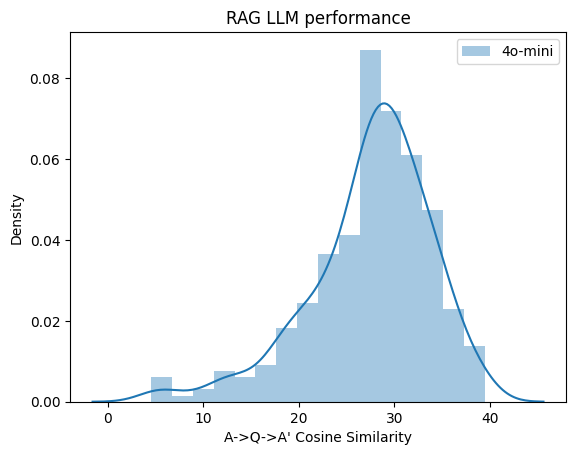

In [12]:
sns.distplot(df['cosine'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity")
plt.legend()

## Q3. Computing the cosine

In [13]:
def normalised_vectors(v):
    norm = np.sqrt((v * v).sum())
    v_norm = v / norm
    return v_norm

In [14]:
def compute_cos_similarity(record):
    answer_orig = record['answer_orig']
    answer_llm = record['answer_llm']
    
    v_llm = embedding_model.encode(answer_llm)
    v_orig = embedding_model.encode(answer_orig)
    
    v_norm_llm = normalised_vectors(v_llm)
    v_norm_orig = normalised_vectors(v_orig)
    
    return v_norm_llm.dot(v_norm_orig)

In [15]:
cos_similarity = []

for i, record in tqdm(df.iterrows(), total=df.shape[0]):
    cos_sim = compute_cos_similarity(record)
    cos_similarity.append(cos_sim)
    
df['cos_similarity'] = cos_similarity
df['cos_similarity'].describe()

  0%|          | 0/300 [00:00<?, ?it/s]

count    300.000000
mean       0.728393
std        0.157755
min        0.125357
25%        0.651273
50%        0.763761
75%        0.836235
max        0.958796
Name: cos_similarity, dtype: float64

In [16]:
percentile_cos_75 = df['cos_similarity'].quantile(0.75)
print(f"Q3 - 75th percentile: {percentile_cos_75}")

Q3 - 75th percentile: 0.8362348675727844


/tmp/ipykernel_23515/2183008882.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df['cos_similarity'], label='4o-mini')


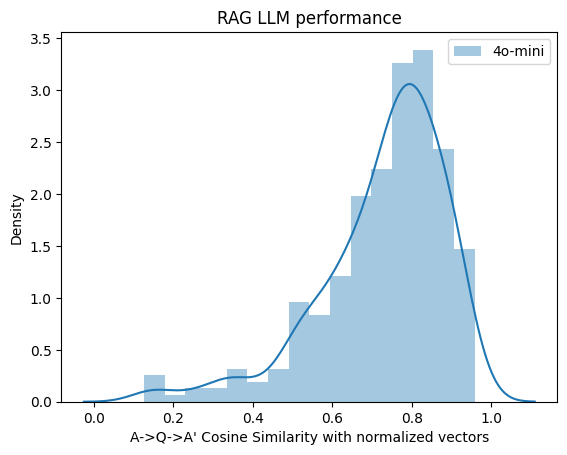

In [17]:
sns.distplot(df['cos_similarity'], label='4o-mini')

plt.title("RAG LLM performance")
plt.xlabel("A->Q->A' Cosine Similarity with normalized vectors")
plt.legend()

## Q4. Rouge

In [18]:
df.iloc[10]

answer_llm        Yes, all sessions are recorded, so if you miss...
answer_orig       Everything is recorded, so you won’t miss anyt...
document                                                   5170565b
question                       Are sessions recorded if I miss one?
course                                    machine-learning-zoomcamp
cosine                                                    32.344707
cos_similarity                                             0.777956
Name: 10, dtype: object

In [19]:
rouge_scorer = Rouge()

scores = rouge_scorer.get_scores(df['answer_llm'], df['answer_orig'])[10]

In [20]:
scores

{'rouge-1': {'r': 0.45454545454545453,
  'p': 0.45454545454545453,
  'f': 0.45454544954545456},
 'rouge-2': {'r': 0.21621621621621623,
  'p': 0.21621621621621623,
  'f': 0.21621621121621637},
 'rouge-l': {'r': 0.3939393939393939,
  'p': 0.3939393939393939,
  'f': 0.393939388939394}}

In [21]:
rouge_1_f_score = scores['rouge-1']['f']

print(f"Q4 - ROUGE-1 F-score: {rouge_1_f_score}")

Q4 - ROUGE-1 F-score: 0.45454544954545456


## Q5. Average rouge score

In [22]:
f_scores = [score['f'] for score in scores.values()]

average_f_score = sum(f_scores) / len(f_scores)

print("Q5 - Average F-score:", average_f_score)

Q5 - Average F-score: 0.35490034990035496


## Q6. Average rouge score for all the data points

In [23]:
scores = []
for llm, orig in zip(df['answer_llm'], df['answer_orig']):
    score = rouge_scorer.get_scores(llm, orig)[0]
    scores.append(score)

scores_df = pd.DataFrame(scores)

# Compute the average ROUGE-2 score
average_rouge_2 = scores_df['rouge-2'].apply(lambda x: x['f']).mean()

display(scores_df)

,rouge-1,rouge-2,rouge-l
0,"{'r': 0.061224489795918366, 'p': 0.21428571428...","{'r': 0.017543859649122806, 'p': 0.07142857142...","{'r': 0.061224489795918366, 'p': 0.21428571428..."
1,"{'r': 0.08163265306122448, 'p': 0.266666666666...","{'r': 0.03508771929824561, 'p': 0.133333333333...","{'r': 0.061224489795918366, 'p': 0.2, 'f': 0.0..."
2,"{'r': 0.32653061224489793, 'p': 0.571428571428...","{'r': 0.14035087719298245, 'p': 0.242424242424...","{'r': 0.30612244897959184, 'p': 0.535714285714..."
3,"{'r': 0.16326530612244897, 'p': 0.32, 'f': 0.2...","{'r': 0.03508771929824561, 'p': 0.071428571428...","{'r': 0.14285714285714285, 'p': 0.28, 'f': 0.1..."
4,"{'r': 0.2653061224489796, 'p': 0.0970149253731...","{'r': 0.07017543859649122, 'p': 0.022346368715...","{'r': 0.22448979591836735, 'p': 0.082089552238..."
...,...,...,...
295,"{'r': 0.6428571428571429, 'p': 0.6666666666666...","{'r': 0.559322033898305, 'p': 0.52380952380952...","{'r': 0.6071428571428571, 'p': 0.6296296296296..."
296,"{'r': 0.6428571428571429, 'p': 0.5454545454545...","{'r': 0.5423728813559322, 'p': 0.4, 'f': 0.460...","{'r': 0.6071428571428571, 'p': 0.5151515151515..."
297,"{'r': 0.6607142857142857, 'p': 0.6491228070175...","{'r': 0.5932203389830508, 'p': 0.5384615384615...","{'r': 0.6428571428571429, 'p': 0.6315789473684..."
298,"{'r': 0.2857142857142857, 'p': 0.3265306122448...","{'r': 0.13559322033898305, 'p': 0.129032258064...","{'r': 0.2857142857142857, 'p': 0.3265306122448..."


In [24]:
print(f"Q6 - Average ROUGE-2 score: {average_rouge_2}")

Q6 - Average ROUGE-2 score: 0.20696501983423318
